## GAE 
1. To prove this, we collect all $r_i$'s and and all $v_{\omega}(s_i)$'s
$$
\begin{split}
(1-\lambda)\sum_{h=0}^{\inf}\lambda^h\delta_{t,h} &= (1-\lambda)\sum_{h=0}^{\inf}\lambda^h(\sum_{i=t}^{t+h}\gamma^{i-t}\cdot r_i + \gamma^{h+1}\cdot v_\omega(s_{t+h+1}) - v_{\omega}(s_t))\\
& = (1-\lambda)\sum_{h=0}^{\inf}(\sum_{i=t}^{t+h}\lambda^h\gamma^{i-t}\cdot r_i) + (1-\lambda)\sum_{h=0}^{\inf}(\gamma^{h+1}\cdot v_\omega(s_{t+h+1}) - v_{\omega}(s_t))\\
& = (1-\lambda)(\gamma^0\sum_{i=0}^{\inf}\lambda^i r_{t} + \gamma^{1}\sum_{i=1}^{\inf}\lambda^i r_{t+1} + \gamma^{2}\sum_{i=2}^{\inf}\lambda^i r_{t+2} + \cdots + \gamma^{h}\sum_{i=h}^{\inf}\lambda^i r_{t+h})+ \sum_{h=0}^{\inf}(1-\lambda)\lambda^h\gamma^{h+1}\cdot v_\omega(s_{t+h+1}) - v_{\omega}(s_t)\\
& = (1-\lambda)\sum_{h=0}^{\inf}\frac{(\gamma\lambda)^h}{1-\lambda}r_t^{h} + \sum_{h=0}^{\inf}(\lambda^h-\lambda^{h+1})\gamma^{h+1}\cdot v_\omega(s_{t+h+1})- v_{\omega}(s_t)\\
& = (1-\lambda)\sum_{h=0}^{\inf}\frac{(\gamma\lambda)^h}{1-\lambda}r_t^{h} + \sum_{h=0}^{\inf}\lambda^h\gamma^{h}\cdot (\gamma v_\omega(s_{t+h+1}) - v_\omega(s_{t+h}))\\
& = \sum_{h=0}^{\inf}(\gamma\lambda)^h\delta_{t+h,0}
\end{split}
$$
2. The role of $\lambda$ is the weight given to each advantage estimator of the $Q$ function. In this case, the longer one has to expand, the less weight is given to the advantage estimator. The role of $\gamma$ is to discount the reward at further timestep as they are less certain.

# PPO

1. 
* The actor acts according to a policy network and interacts with the environment, the critic observes the interactions and evaluates the rewards (critizes the actor's actions). The `step` method basically lets the actor interact and the critic evaluate, returning the state action tuples and the value by the critic.
* The GaussianActor returns a probability density function parameterized by the action space while the CategoricalActor returns a probability distribution function parameterized by the set of discrete actions. The PDF for continuous action is a guassian distribution with a mean and a variance, of which the mean is the output of the network; the PDF for discrete actions is a categorical distribution with a weight for each action, which are the outputs of the network.
* The std determines how randon the actor acts. We can use a larger std to encourage exploration and a smaller std to encourage exploitation. It is a hyperparameter in our model.
* GAE-Lambda essentially determines our effective rollout length, and thus determines our bias-variance trade-off. If we have large lambda, then we have smaller bias but larger variance and vice versa. The lambda is absored into the discount via the trick in the previous section.
* The last step of the trajectory is either the value returned by going another step if the trajectory is cutoff or 0 if the trajectory is complete
* 

In [32]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [66]:
w = -1
rmap = np.array([   [w,w,w,w,w,w,w,w,w,w,w,w,w,w,w],
                    [w,1,1,1,w,w,1,1,1,w,w,1,1,1,w],
                    [w,1,w,w,w,w,1,w,w,w,w,1,w,w,w],
                    [w,1,w,w,w,w,1,1,1,w,w,1,1,1,w],
                    [w,1,w,w,w,w,w,w,1,w,w,1,w,w,w],
                    [w,1,1,1,w,w,1,1,1,w,w,1,1,1,w],
                    [w,1,1,1,w,1,1,1,w,1,w,1,1,1,w],
                    [w,w,w,1,w,1,w,1,w,1,w,1,w,1,w],
                    [w,1,1,1,w,1,1,1,w,1,w,1,w,1,w],
                    [w,1,w,w,w,w,w,1,w,1,w,1,w,1,w],
                    [w,1,1,1,1,1,1,1,1,1,1,1,1,1,w],
                    [w,w,w,w,w,w,w,w,w,w,w,w,w,w,w]])

In [67]:
traveled = np.zeros_like(rmap)
traveled[5,7] = 1
traveled[6,7] = 1
l = []
r = np.zeros_like(rmap)
r_dir = np.zeros((rmap.shape[0], rmap.shape[1],2))
r[5,7] = 100
r[6,7] = 100
l.append((5,7))
l.append((6,7))
while len(l)>0:
    curx, cury = l.pop(0)
    for (x,y) in [(curx-1, cury), (curx+1, cury), (curx, cury-1), (curx, cury+1)]:
        if x< 0 or x > 11:
            continue
        if y<0 or y>14:
            continue
        if traveled[x,y] == 1:
            continue
        if rmap[x,y] < 0:
            r[x,y] = -10
        else:
            traveled[x,y] = 1
            l.append((x,y))
            curr = r[curx, cury]
            rew = curr - 3
            r[x,y] = rew
            r_dir[x,y,:] = [x-curx, y-cury]
r += (r==0) * -10
    


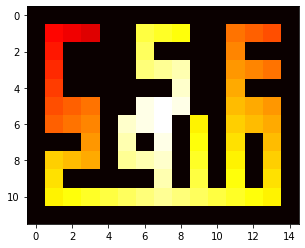

In [68]:
plt.imshow(r, cmap='hot', interpolation='nearest')

In [69]:
cdict = dict()
cdict[(-1,0)] = (255,0,0)
cdict[(1,0)] = (0, 255,0)
cdict[(0,-1)] = (0,0,255)
cdict[(0,1)] = (128,128,0)
cdict[(0,0)] = (0,0,0)


In [70]:
c_dir = np.zeros((r_dir.shape[0], r_dir.shape[1], 3))
for i in range(r_dir.shape[0]):
    for j in range(r_dir.shape[1]):
        c_dir[i,j,:] = cdict[(r_dir[i,j,0], r_dir[i,j,1])]
c_dir[5,7] = [255,255,255]
c_dir[6,7] = [255,255,255]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


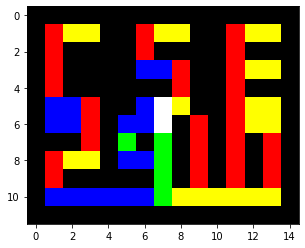

In [71]:
plt.imshow(c_dir, interpolation='nearest')

In [72]:
r_dir

array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., 